1. Загрузка изображения и преобразование цветного к полутоновому

In [27]:
from matplotlib import pyplot as plt
%matplotlib inline
from skimage import io 
from PIL import Image
import numpy as np
import copy

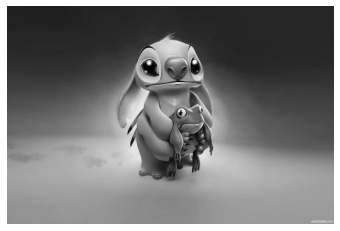

In [28]:
image = Image.open("1.jpg") #Открываем изображение.  
width = image.size[0] #Определяем ширину. 
height = image.size[1] #Определяем высоту. 
pix = image.load() #Выгружаем значения пикселей.

for i in range(width):
    for j in range(height):
            r = pix[i, j][0]
            g = pix[i, j][1]
            b = pix[i, j][2]
            r, g, b = pix[i, j]
            S = (r + g + b) // 3
            pix[i, j] = S, S, S
            
image.save("gray.jpg", "JPEG")
img = io.imread("gray.jpg")
plt.axis("off")
plt.imshow(img)

2. Квантование по яркости (с ручным заданием количества уровней)

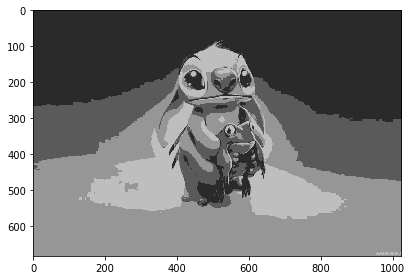

In [13]:
from sklearn.cluster import KMeans

img = Image.open('gray.jpg')
original = io.imread('gray.jpg')
n_lvls = 4

arr = original.reshape((-1, 3))
kmeans = KMeans(n_clusters=n_lvls, random_state=42).fit(arr)
labels = kmeans.labels_
centers = kmeans.cluster_centers_
less_colors = centers[labels].reshape(original.shape).astype('uint8')
    
io.imshow(less_colors)

3. Бинаризация.

    3.1. Бинаризация Оцу глобальная.

105


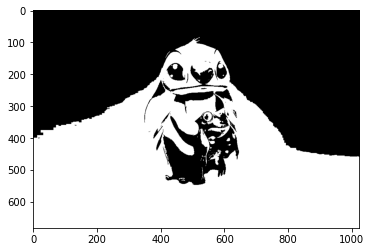

In [35]:
def count_gray_colors(image):
    count_colors = list(0 for i in range(256))
    cells = image.load()
    for x in range(image.size[0]):
        for y in range(image.size[1]):
            count_colors[cells[x, y][0]] += 1
    return count_colors

def gray_pixels(image):
    size = image.size[0] * image.size[1]
    answer = [0 for i in range(size)]
    cells = image.load()
    stepper = 0
    for x in range(image.size[0]):
        for y in range(image.size[1]):
                answer[stepper] = cells[x,y][0]
                stepper += 1
    return answer

def thresh(idensity):
    intensity_sum = sum([idensity[i] * i for i in range(len(idensity))])    
    size_photo = sum(idensity)
    max_thresh = 0
    max_sigma = 0.0
    a = 0
    sumB = 0
    for i in range(256):
        a += idensity[i]
        if a == 0:
            continue
        b = size_photo - a
        if b == 0:
            break
        sumB += i * idensity[i]
        x = sumB / a
        y = (intensity_sum - sumB) / b
        sigma = a * b * (x - y) ** 2
        if sigma > max_sigma:
            max_sigma = sigma
            max_thresh = i
    return max_thresh

def threshold_otsu_global(image):
    gray_image = gray_pixels(copy.deepcopy(image))
    gray_colors = count_gray_colors(img)
    return thresh(gray_colors);

def paint_threshold(image, t):
    result = copy.deepcopy(image)
    cells = result.load()
    for i in range(result.size[0]):
        for j in range(result.size[1]):
            color = 0 if cells[i,j][0] < t else 255
            cells[i,j] = color, color,color
                
    return result

img = Image.open('1.jpg')
img_gray = Image.open("gray.jpg")
gray_colors = count_gray_colors(img_gray)
t = thresh(gray_colors)

print(t)
cells = img_gray.load()
for i in range(img_gray.size[0]):
        for j in range(img_gray.size[1]):
            color = 0 if cells[i,j][0] < t else 255
            cells[i,j] = color, color,color
plt.imshow(img_gray)

    3.2. Бинаризация методом Оцу локальная (с предварительным разбиением на фрагменты - по каждому своя бинаризация)

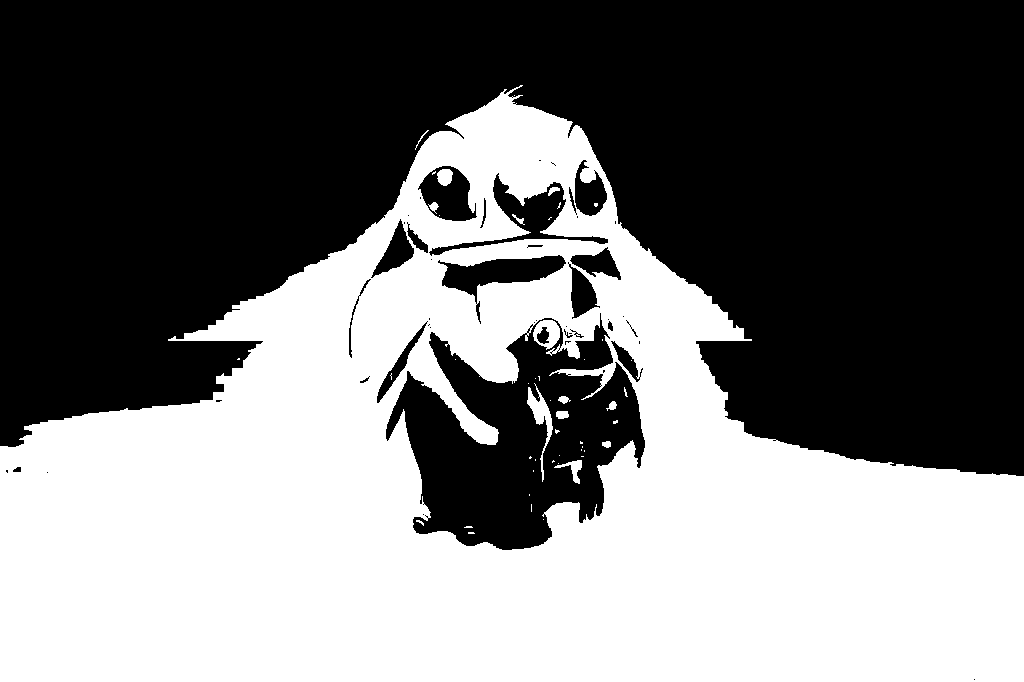

In [53]:
import image_slicer
tiles = image_slicer.slice("gray.jpg", 4, save=False)

for tile in tiles:
    gray_im = copy.deepcopy(tile.image)
    gray_colors = count_gray_colors(gray_im)
    t = thresh(gray_colors)
    cells = gray_im.load()
    for i in range(gray_im.size[0]):
        for j in range(gray_im.size[1]):
            color = 0 if cells[i,j][0] < t else 255
            cells[i,j] = color, color,color
    tile.image = gray_im
    
image_slicer.join(tiles)

Бинаризация методом Оцу иерархическая

[0, 61, 105, 162, 255]


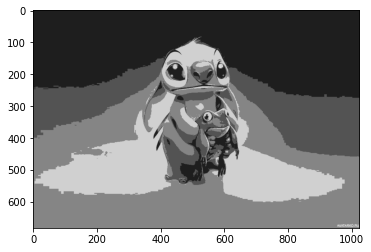

In [68]:
img_gray = Image.open("gray.jpg")

def by_otsu_hierarchical(grayImage, step):
    idensity = count_gray_colors(grayImage)
    t = [0, 255]
    threshol_otsu_recn(idensity, t, step)
    return t
    
    
def threshol_otsu_recn(idensity, ts, step):
    if step == 0:
        return
    step -= 1
    
    t1 = thresh(idensity)
    
    ts.append(t1)

    l = [idensity[i] if i < t1 else 0 for i in range(256)]
    r = [idensity[i] if i >= t1 else 0 for i in range(256)]
    
    threshol_otsu_recn(l, ts, step)
    threshol_otsu_recn(r, ts, step)

    
ts = by_otsu_hierarchical(img_gray, 2)
ts.sort()
print(ts)


cells = img_gray.load()

for x in range(img_gray.size[0]):
    for y in range(img_gray.size[1]):
        for n in range(len(ts)):
             if ts[n - 1] <= cells[x, y][0] < ts[n]:
                    c = (ts[n - 1] + ts[n]) // 2
                    cells[x, y] = c, c, c
                    break
plt.imshow(img_gray)